### Application of GPcounts with Negative Binomial likelihood on spatial data from Mouse olfactory bulb to identify spatially expressed genes. 

In the following example, we use Mouse olfactory bulb spatially dependent data-set, published by <a href="https://science.sciencemag.org/content/353/6294/78" target="_blank">Stahl et al.</a>. 
To correct for the library size of the spatial samples, we normalise our data by multiplying the mean by a location specific scale factor. To calculate the scale factors we perform negative binomial regression with identity link function using the glm function with negative binomial and identity link function as implemented below. 


In [1]:
import pandas as pd 
import numpy as np 
import gpflow
import tensorflow as tf
from GPcounts import NegativeBinomialLikelihood
from GPcounts.RNA_seq_GP import rna_seq_gp
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We load the expression matrix and extract the spatial locations 'x' and 'y'

In [2]:
# spatial expression counts matrix
Y = pd.read_csv('../data/MouseOB/Rep11_MOB_0.csv', index_col=[0])
Y = Y.T[Y.sum(0) >= 3].T # Filter out genes with less than 3 total counts

In [3]:
spatial_locations = pd.DataFrame(index=Y.index)
spatial_locations['x'] = Y.index.str.split('x').str.get(0).map(float)
spatial_locations['y'] = Y.index.str.split('x').str.get(1).map(float)

In [4]:
spatial_locations['total_counts'] = Y.sum(1)
Y = Y.loc[spatial_locations.index]
X = spatial_locations[['x', 'y']]
# scale = pd.read_csv('../data/MouseOB/scales_nb.txt', sep="\t") # load the file with the scale factors 

Calculate the scale coefficients

In [ ]:
import statsmodels.formula.api as smf 
import statsmodels.api as sm
scales = []
for i in range(0,len(Y.columns)):
    model=smf.glm(formula = "Y.iloc[:,i]~0+spatial_locations['total_counts']", data=Y,family=sm.families.NegativeBinomial(sm.families.links.identity())).fit()
    res = model.params[0]*spatial_locations['total_counts']
    scales.append(res)
scalesdf=pd.DataFrame(scales)
scalesdf=scalesdf.T

In [8]:
print(scalesdf.head())

               total_counts  total_counts  total_counts  total_counts  \
16.92x9.015        0.358224      0.378969      1.334467      0.971175   
16.945x11.075      0.705199      0.746039      2.627032      1.911856   
16.97x10.118       0.237754      0.251523      0.885691      0.644573   
16.939x12.132      0.432823      0.457889      1.612368      1.173421   
16.949x13.055      0.355383      0.375964      1.323885      0.963474   

               total_counts  total_counts  total_counts  total_counts  \
16.92x9.015        0.874044      3.135066      0.604092      1.643130   
16.945x11.075      1.720643      6.171691      1.189216      3.234667   
16.97x10.118       0.580106      2.080756      0.400939      1.090552   
16.939x12.132      1.056063      3.787940      0.729894      1.985311   
16.949x13.055      0.867113      3.110205      0.599302      1.630101   

               total_counts  total_counts  ...  total_counts  total_counts  \
16.92x9.015        1.792824      0.905178  .

After filtering, the whole data-set contains 14,859 genes but for simplicity we run this example on the first 20 genes. This will take a few minutes. For the purposes of comparison, we provide a file (../data/MouseOB/SE_genes_comparison.csv) with the all spatially expressed genes found by running GPcounts on the whole data-set as well as the spatially expressed genes identified by [SpatialDE](https://github.com/Teichlab/SpatialDE/tree/cb5deb8c24e7c98c77672784b43cef41b2f24d99) package.    

In [9]:
Y = Y.T
Y_run = Y.iloc[0:20,:] # select first 20 genes to run GPcounts
X = X[['x', 'y']]

To run the scaled version of the GPcounts, where the negative binomial mean is multiplied by the pre-calculated scale factors (scalesdf), we should use the three optional arguments in the function Fit_GPcounts:  'scale=scalesdf' and 'nb_scaled'.
The 'scale' argument contains the file with the scale factors, the 'nb_scaled=True' argument is used to  activate the scaled (multiplicative) version.  

In [13]:
gene_name = []
nb_scaled = True # set the nb_scaled argument to True to pass the scale factors 
gene_name = Y_run.index
likelihood = 'Negative_binomial' 
gp_counts = rna_seq_gp(X,Y_run.loc[gene_name], scale = scalesdf, safe_mode=False)

We run the One_sample_test with negative binomial likelihood for the 20 genes. Then we run gp_counts.calculate_FDR and the 'results' will show the following:

* Name of the gene
* Dynamic_model_log_likelihood - Likelihood of the dynamic model  
* Constant_model_log_likelihood - Likelihood of the constant ('null') model
* log_likelihood_ratio - Ratio between the dynamic and constant models
* p value - statistical significance based on P value 
* q value - Statistical significance based on the "adjusted p value" for the false discovery rate or q value 

In [14]:
log_likelihood_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

  0%|          | 0/20 [00:00<?, ?it/s]

closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B7C0F6490>>
tf.Tensor(-249.24999525002835, shape=(), dtype=float64)
model 1 log likelihood = -249.24999525002835, alpha = None, km = 0.08544251597723387
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B7C12ECA0>>


  5%|▌         | 1/20 [00:06<02:11,  6.93s/it]

tf.Tensor(-249.51508771792246, shape=(), dtype=float64)
results: [-249.24999525002835, -249.51508771792246, 0.2650924678941067]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B7CB65460>>
tf.Tensor(-264.3758013508793, shape=(), dtype=float64)
model 1 log likelihood = -264.3758013508793, alpha = None, km = 0.17421105217447125
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B7CC10430>>


 10%|█         | 2/20 [00:09<01:23,  4.64s/it]

tf.Tensor(-264.4041217101651, shape=(), dtype=float64)
results: [-264.3758013508793, -264.4041217101651, 0.0283203592857717]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B72A41850>>
tf.Tensor(-470.15538075155007, shape=(), dtype=float64)
model 1 log likelihood = -470.15538075155007, alpha = None, km = 0.24950039581490507
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B7CA84DF0>>


 15%|█▌        | 3/20 [00:12<01:06,  3.88s/it]

tf.Tensor(-470.1821323291854, shape=(), dtype=float64)
results: [-470.15538075155007, -470.1821323291854, 0.02675157763530933]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B7CA84DF0>>
tf.Tensor(-425.48437216447337, shape=(), dtype=float64)
model 1 log likelihood = -425.48437216447337, alpha = None, km = 0.6392787774985671
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B7CCA8E80>>


 20%|██        | 4/20 [00:17<01:04,  4.02s/it]

tf.Tensor(-426.37413603600567, shape=(), dtype=float64)
results: [-425.48437216447337, -426.37413603600567, 0.8897638715322955]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B7CAE65B0>>
tf.Tensor(-399.7195242309625, shape=(), dtype=float64)
model 1 log likelihood = -399.7195242309625, alpha = None, km = 0.28121961347120306
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B00419610>>


 25%|██▌       | 5/20 [00:20<00:58,  3.92s/it]

tf.Tensor(-399.7650816966971, shape=(), dtype=float64)
results: [-399.7195242309625, -399.7650816966971, 0.045557465734589186]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B004B20A0>>
tf.Tensor(-613.4959487429312, shape=(), dtype=float64)
model 1 log likelihood = -613.4959487429312, alpha = None, km = 0.10604949032673087
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B004F3310>>


 30%|███       | 6/20 [00:25<00:55,  3.98s/it]

tf.Tensor(-615.9665481105578, shape=(), dtype=float64)
results: [-613.4959487429312, -615.9665481105578, 2.470599367626619]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B006C2EB0>>
tf.Tensor(-343.35792573499793, shape=(), dtype=float64)
model 1 log likelihood = -343.35792573499793, alpha = None, km = 0.6171371568409191
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B0066EAC0>>


 35%|███▌      | 7/20 [00:29<00:53,  4.11s/it]

tf.Tensor(-344.2816626677228, shape=(), dtype=float64)
results: [-343.35792573499793, -344.2816626677228, 0.9237369327248643]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B02F4A0D0>>
tf.Tensor(-504.47020039626443, shape=(), dtype=float64)
model 1 log likelihood = -504.47020039626443, alpha = None, km = 0.13899541485810007
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B03029760>>


 40%|████      | 8/20 [00:32<00:45,  3.80s/it]

tf.Tensor(-506.2746144521109, shape=(), dtype=float64)
results: [-504.47020039626443, -506.2746144521109, 1.8044140558464505]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B031036A0>>
tf.Tensor(-519.8431761516315, shape=(), dtype=float64)
model 1 log likelihood = -519.8431761516315, alpha = None, km = 0.15408961899588314
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B032B2550>>


 45%|████▌     | 9/20 [00:35<00:39,  3.60s/it]

tf.Tensor(-519.9013974584611, shape=(), dtype=float64)
results: [-519.8431761516315, -519.9013974584611, 0.05822130682963689]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B0334BA00>>
tf.Tensor(-404.3885481041988, shape=(), dtype=float64)
model 1 log likelihood = -404.3885481041988, alpha = None, km = 0.28928507533820985
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B0453ED30>>


 50%|█████     | 10/20 [00:39<00:37,  3.73s/it]

tf.Tensor(-404.38855313030444, shape=(), dtype=float64)
results: [-404.3885481041988, -404.38855313030444, 5.026105668548553e-06]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B045D4E80>>
tf.Tensor(-701.9637365269602, shape=(), dtype=float64)
model 1 log likelihood = -701.9637365269602, alpha = None, km = 0.05457041430816636
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B045D4A30>>


 55%|█████▌    | 11/20 [00:44<00:36,  4.07s/it]

tf.Tensor(-707.9107751689912, shape=(), dtype=float64)
results: [-701.9637365269602, -707.9107751689912, 5.947038642030975]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B046A8FA0>>
tf.Tensor(-645.9429398236699, shape=(), dtype=float64)
model 1 log likelihood = -645.9429398236699, alpha = None, km = 0.0716059841539536
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B046E8B20>>


 60%|██████    | 12/20 [00:48<00:33,  4.15s/it]

tf.Tensor(-646.2565651948273, shape=(), dtype=float64)
results: [-645.9429398236699, -646.2565651948273, 0.31362537115739997]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B04881EB0>>
tf.Tensor(-1112.1219379839192, shape=(), dtype=float64)
model 1 log likelihood = -1112.1219379839192, alpha = None, km = 0.0880574098896998
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B0498E1F0>>


 65%|██████▌   | 13/20 [01:00<00:43,  6.27s/it]

tf.Tensor(-1123.8805865065021, shape=(), dtype=float64)
results: [-1112.1219379839192, -1123.8805865065021, 11.758648522582916]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B04B442B0>>
tf.Tensor(-360.3162527218113, shape=(), dtype=float64)
model 1 log likelihood = -360.3162527218113, alpha = None, km = 0.26716997962335376
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B04B371F0>>


 70%|███████   | 14/20 [01:05<00:35,  5.90s/it]

tf.Tensor(-360.31625036332156, shape=(), dtype=float64)
results: [-360.3162527218113, -360.31625036332156, -2.3584897235195967e-06]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B08C3FAC0>>
tf.Tensor(-637.3469828515574, shape=(), dtype=float64)
model 1 log likelihood = -637.3469828515574, alpha = None, km = 0.03172238353435801
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B08C3FE50>>


 75%|███████▌  | 15/20 [01:08<00:26,  5.30s/it]

tf.Tensor(-638.2421846352875, shape=(), dtype=float64)
results: [-637.3469828515574, -638.2421846352875, 0.8952017837300446]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B08DE8AC0>>
tf.Tensor(-215.29385530465115, shape=(), dtype=float64)
model 1 log likelihood = -215.29385530465115, alpha = None, km = 0.7184761496788401
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B08C721F0>>


 80%|████████  | 16/20 [01:12<00:19,  4.85s/it]

tf.Tensor(-215.29445338733194, shape=(), dtype=float64)
results: [-215.29385530465115, -215.29445338733194, 0.0005980826807956419]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B02F06C70>>
tf.Tensor(-669.3580034421012, shape=(), dtype=float64)
model 1 log likelihood = -669.3580034421012, alpha = None, km = 0.013047481819992737
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B7C957D00>>


 85%|████████▌ | 17/20 [01:17<00:14,  4.78s/it]

tf.Tensor(-671.0633799737391, shape=(), dtype=float64)
results: [-669.3580034421012, -671.0633799737391, 1.705376531637853]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B7CA9B850>>
tf.Tensor(-516.4739903396302, shape=(), dtype=float64)
model 1 log likelihood = -516.4739903396302, alpha = None, km = 0.16103936709941163
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B7CA9F910>>


 90%|█████████ | 18/20 [01:22<00:09,  4.91s/it]

tf.Tensor(-516.475587035677, shape=(), dtype=float64)
results: [-516.4739903396302, -516.475587035677, 0.0015966960468176694]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B0A1EAAC0>>
tf.Tensor(-660.5943046026929, shape=(), dtype=float64)
model 1 log likelihood = -660.5943046026929, alpha = None, km = 0.1831763649238093
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B08E02A90>>


 95%|█████████▌| 19/20 [01:29<00:05,  5.50s/it]

tf.Tensor(-683.3603552852926, shape=(), dtype=float64)
results: [-660.5943046026929, -683.3603552852926, 22.76605068259971]
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B0A374580>>
tf.Tensor(-531.7785963881521, shape=(), dtype=float64)
model 1 log likelihood = -531.7785963881521, alpha = None, km = 0.05855508693833409
closure = <bound method InternalDataTrainingLossMixin.training_loss of <gpflow.models.vgp.VGP object at 0x0000021B0A468280>>


100%|██████████| 20/20 [01:36<00:00,  4.81s/it]

tf.Tensor(-534.3534501776493, shape=(), dtype=float64)
results: [-531.7785963881521, -534.3534501776493, 2.5748537894971832]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
Nrf1,-249.249995,-249.515088,0.265092
Zbtb5,-264.375801,-264.404122,0.028320
Ccnl1,-470.155381,-470.182132,0.026752
Lrrfip1,-425.484372,-426.374136,0.889764
Bbs1,-399.719524,-399.765082,0.045557
Lix1,-613.495949,-615.966548,2.470599
Whrn,-343.357926,-344.281663,0.923737
Ate1,-504.470200,-506.274614,1.804414
Ubac1,-519.843176,-519.901397,0.058221
Rab34,-404.388548,-404.388553,0.000005


In [15]:
results = gp_counts.calculate_FDR(log_likelihood_ratio)
results

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,p_value,q_value
Nrf1,-249.249995,-249.515088,0.265092,4.665291e-01,7.775485e-01
Zbtb5,-264.375801,-264.404122,0.028320,8.118864e-01,1.000000e+00
Ccnl1,-470.155381,-470.182132,0.026752,8.170759e-01,1.000000e+00
Lrrfip1,-425.484372,-426.374136,0.889764,1.822073e-01,3.644147e-01
Bbs1,-399.719524,-399.765082,0.045557,7.627645e-01,1.000000e+00
Lix1,-613.495949,-615.966548,2.470599,2.622384e-02,1.048954e-01
Whrn,-343.357926,-344.281663,0.923737,1.740775e-01,3.644147e-01
Ate1,-504.470200,-506.274614,1.804414,5.747361e-02,1.850654e-01
Ubac1,-519.843176,-519.901397,0.058221,7.329253e-01,1.000000e+00
Rab34,-404.388548,-404.388553,0.000005,9.974703e-01,1.000000e+00


Plot some spatially expressed genes from the data-set based on the q values provided in file 'SE_genes_comparison.csv'

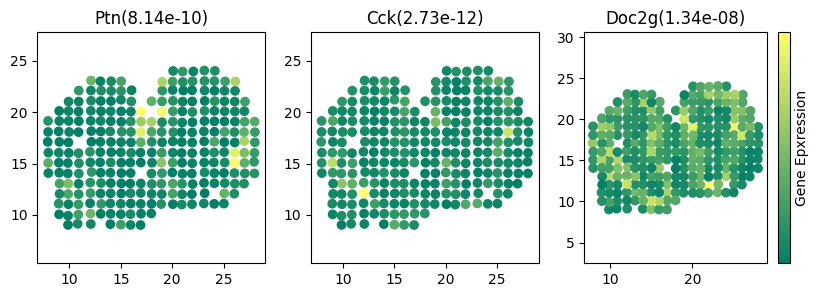

In [16]:
from matplotlib import rcParams
plt.rcParams["figure.figsize"] = [10,3]
m = ['Ptn(8.14e-10)', 'Cck(2.73e-12)', 'Doc2g(1.34e-08)']
for i, g in enumerate(['Ptn', 'Cck', 'Doc2g']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(m[i])
    plt.axis('equal')
plt.colorbar(ticks=[0,1],label = 'Gene Epxression')

plt.show()


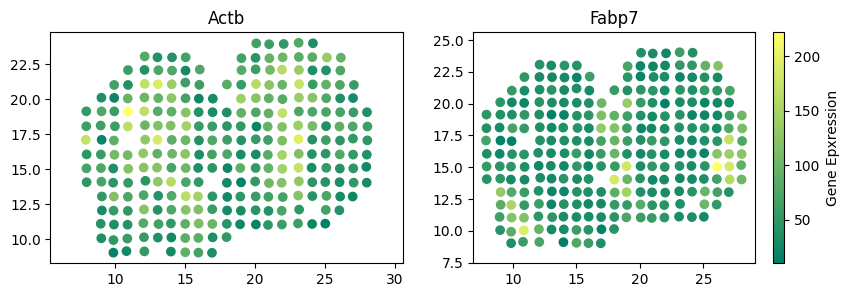

In [17]:
from matplotlib import rcParams
plt.rcParams["figure.figsize"] = [10,3]
m = ['Actb', 'Fabp7']
for i, g in enumerate(['Actb', 'Fabp7']):
    plt.subplot(1, 2, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(m[i])
    plt.axis('equal')
plt.colorbar(label = 'Gene Epxression')

# plt.show()
plt.savefig('svgenes_1.pdf')

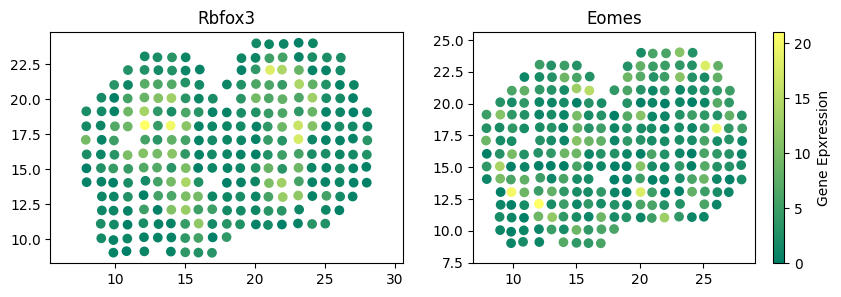

In [19]:
from matplotlib import rcParams
plt.rcParams["figure.figsize"] = [10,3]
m = ['Rbfox3', 'Eomes']
for i, g in enumerate(['Rbfox3', 'Eomes']):
    plt.subplot(1, 2, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(m[i])
    plt.axis('equal')
plt.colorbar(label = 'Gene Epxression')
plt.savefig('svgenes_2.pdf')
# plt.show()

 We plot two genes with very low expression which have been identified as spatially expressed by SpatialDE but not by GPcounts 

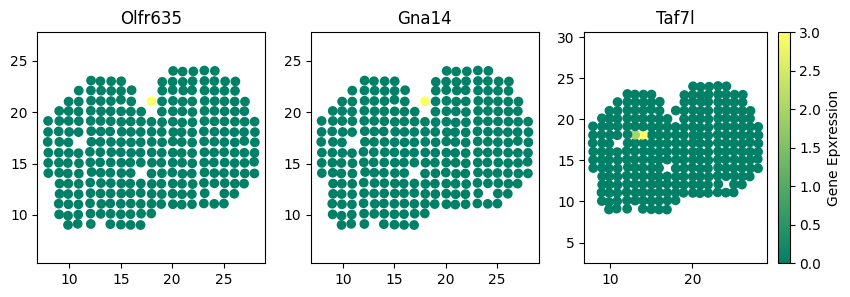

In [20]:
plt.rcParams["figure.figsize"] = [10,3]
n = ['Olfr635','Gna14', 'Taf7l']
for i, g in enumerate(['Olfr635','Gna14', 'Taf7l']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(n[i])
    plt.axis('equal')
plt.colorbar(label = 'Gene Epxression')